Problem 5: Price Pattern Extraction | K-means

The Zigzag indicator is a technical analysis tool used to identify significant changes or reversals in price trends. It helps traders and analysts visualize the most prominent price swings in a financial time series, filtering out smaller fluctuations and noise.
The Zigzag indicator connects significant highs and lows in a chart by drawing lines or segments, highlighting the major price movements. It aims to simplify price analysis by focusing on the turning points or pivot levels that indicate potential trend changes.
In this problem, our objective is to utilize the K-means algorithm for extracting price patterns from the Zigzag indicator. We have already been provided with the implementation of the Zigzag indicator, which we will use exclusively for pattern extraction. The output of this indicator is visualized in the form of shape (a). In this implementation we also specified the trend for each leg.


LOAD DATA

In [3]:
import pandas as pd

# Load Gold H1 data
data = pd.read_csv('data.csv')

# Set date oclumn to datetime
data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', utc=True)

# change local time name to date
data.rename(columns={'Local time': 'Date'}, inplace=True)

# set index to date
data.set_index('Date', inplace=True)

# drop rows with volume = 0
data = data[data['Volume'] != 0]


print(len(data))
data.head()



31890


Open      High       Low     Close  \
Date                                                                
2018-01-01 23:00:00+00:00  1302.922  1307.602  1302.231  1306.711   
2018-01-02 00:00:00+00:00  1306.711  1307.308  1305.211  1306.292   
2018-01-02 01:00:00+00:00  1306.291  1306.952  1304.171  1306.141   
2018-01-02 02:00:00+00:00  1306.142  1306.772  1305.418  1305.949   
2018-01-02 03:00:00+00:00  1305.941  1307.422  1305.381  1306.438   

                                 Volume  
Date                                     
2018-01-01 23:00:00+00:00  1.626430e+06  
2018-01-02 00:00:00+00:00  2.392190e+06  
2018-01-02 01:00:00+00:00  2.997380e+06  
2018-01-02 02:00:00+00:00  2.441420e+06  
2018-01-02 03:00:00+00:00  2.557650e+06

ZIG ZAG ANDICATOR

In [4]:

import numpy as np
#import ta

def time_price_distance(v1, v2, t1, t2, atr):
    return abs(v2 - v1) / atr + abs(t2 - t1) / 4

def extract_async_peaks(data, left_alpha, right_alpha, atr_window, arrow_margin_plot_coef=0.5):
    # Intialize max_peaks and min_peaks with NaN
    max_peaks, min_peaks = [np.nan]*len(data), [np.nan]*len(data)

    # Extract local max peaks
    for i in range(atr_window, len(data)):
        atr = data['ATR'][i]
        is_max = True
        # Right side check
        for j in range(i+1, len(data)):
            if data['High'][j] > data['High'][i]:
                is_max = False
                break
            if time_price_distance(data['High'][i], data['Low'][j], i, j, atr) > right_alpha:
                break
        # Left side check
        if is_max:
            for j in range(i-1, 0, -1):
                if data['High'][j] > data['High'][i]:
                    is_max = False
                    break
                if time_price_distance(data['High'][i], data['Low'][j], i, j, atr) > left_alpha:
                    break
        if is_max:
            max_peaks[i] = data['High'][i] + arrow_margin_plot_coef * atr

    # Extract local min peaks
    for i in range(atr_window, len(data)):
        atr = data['ATR'][i]
        is_min = True
        # Right side check
        for j in range(i+1, len(data)):
            if data['Low'][j] < data['Low'][i]:
                is_min = False
                break
            if time_price_distance(data['Low'][i], data['High'][j], i, j, atr) > right_alpha:
                break
        # Left side check
        if is_min:
            for j in range(i-1, 0, -1):
                if data['Low'][j] < data['Low'][i]:
                    is_min = False
                    break
                if time_price_distance(data['Low'][i], data['High'][j], i, j, atr) > left_alpha:
                    break
        if is_min:
            min_peaks[i] = data['Low'][i] - arrow_margin_plot_coef * atr

    # remove peaks that are in a sequence
    for i in range(atr_window, len(data)):
        if not np.isnan(max_peaks[i]):
            # check for next peak (it sould be a min peak)
            for j in range(i+1, len(data)):
                if np.isnan(max_peaks[j]):
                    break
                if not np.isnan(max_peaks[j]):
                    max_peaks[j] = np.nan
        if not np.isnan(min_peaks[i]):
            # check for next peak (it sould be a max peak)
            for j in range(i+1, len(data)):
                if np.isnan(min_peaks[j]):
                    break
                if not np.isnan(min_peaks[j]):
                    min_peaks[j] = np.nan

    # remove peaks in a same candle
    for i in range(atr_window, len(data)):
        if not np.isnan(max_peaks[i]) and not np.isnan(min_peaks[i]):
            if data['Close'][i] > data['Open'][i]:
                min_peaks[i] = np.nan
            else:
                max_peaks[i] = np.nan

    return max_peaks, min_peaks

def extract_middle_paeks(data, alpha, atr_window, arrow_margin_plot_coef=0.5):
    # Intialize max_peaks and min_peaks with NaN
    max_middle_peaks, min_middle_peaks = extract_async_peaks(data, alpha, alpha, atr_window, arrow_margin_plot_coef=0.5)

    # fill between middle peaks
    for i in range(atr_window, len(data)):
        if not np.isnan(max_middle_peaks[i]):
            # check for next peak (it sould be a min peak)
            for j in range(i+1, len(data)):
                if not np.isnan(max_middle_peaks[j]):
                    # find min index between i and j
                    min_index = np.argmin(data['Low'][i+1:j]) + i+1
                    min_middle_peaks[min_index] = data['Low'][min_index] - arrow_margin_plot_coef * data['ATR'][min_index]
                    break
                if not np.isnan(min_middle_peaks[j]):
                    break
        if not np.isnan(min_middle_peaks[i]):
            # check for next peak (it sould be a max peak)
            for j in range(i+1, len(data)):
                if not np.isnan(min_middle_peaks[j]):
                    # find max index between i and j
                    max_index = np.argmax(data['High'][i+1:j]) + i+1
                    max_middle_peaks[max_index] = data['High'][max_index] + arrow_margin_plot_coef * data['ATR'][max_index]
                    break
                if not np.isnan(max_middle_peaks[j]):
                    break

    return max_middle_peaks, min_middle_peaks

def extract_list_of_lines(data):
    lines = []
    trends = []
    start_point, end_point = None, None
    trend = 'w'
    for i in range(len(data)):
        if not np.isnan(data['MaxMiddlePeaks'][i]):
            if end_point is not None:
                start_point = end_point
            end_point = (data.index[i], data['High'][i])
            if start_point is not None:
                lines.append([start_point, end_point])
                trends.append(trend)
        if not np.isnan(data['MinMiddlePeaks'][i]):
            if end_point is not None:
                start_point = end_point
            end_point = (data.index[i], data['Low'][i])
            if start_point is not None:
                lines.append([start_point, end_point])
                trends.append(trend)
        if not np.isnan(data['MaxPeaks'][i]):
            trend = 'b'
        elif not np.isnan(data['MinPeaks'][i]):
            trend = 'r'
    return lines, trends

def calculate_atr(data, window):
    trs = [np.nan] * len(data)
    atr = [np.nan] * len(data)

    # Calculate True Range (TR)
    for i in range(1, len(data)):
        high = data['High'][i]
        low = data['Low'][i]
        close_prev = data['Close'][i - 1]
        tr = max(high - low, abs(high - close_prev), abs(low - close_prev))
        trs[i] = tr

    # Calculate ATR
    atr[window] = np.mean(trs[1:window+1])  # Initial ATR calculation using the window size

    for i in range(window + 1, len(data)):
        atr[i] = (atr[i-1] * (window - 1) + trs[i]) / window

    return atr

# Calculate ATR for the data

atr_window = 200
left_alpha = 10
right_alpha = 2
arrow_margin_plot_coef = 0.5
data['ATR'] = calculate_atr(data, atr_window)
#data['ATR'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window=atr_window, fillna=False)
data['MaxPeaks'], data['MinPeaks'] = extract_async_peaks(data, left_alpha, right_alpha, atr_window, arrow_margin_plot_coef)
data['MaxMiddlePeaks'], data['MinMiddlePeaks'] = extract_middle_paeks(data, right_alpha, atr_window, arrow_margin_plot_coef)


PLOT

In [5]:
!pip install --upgrade mplfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 3.0 MB/s eta 0:00:00


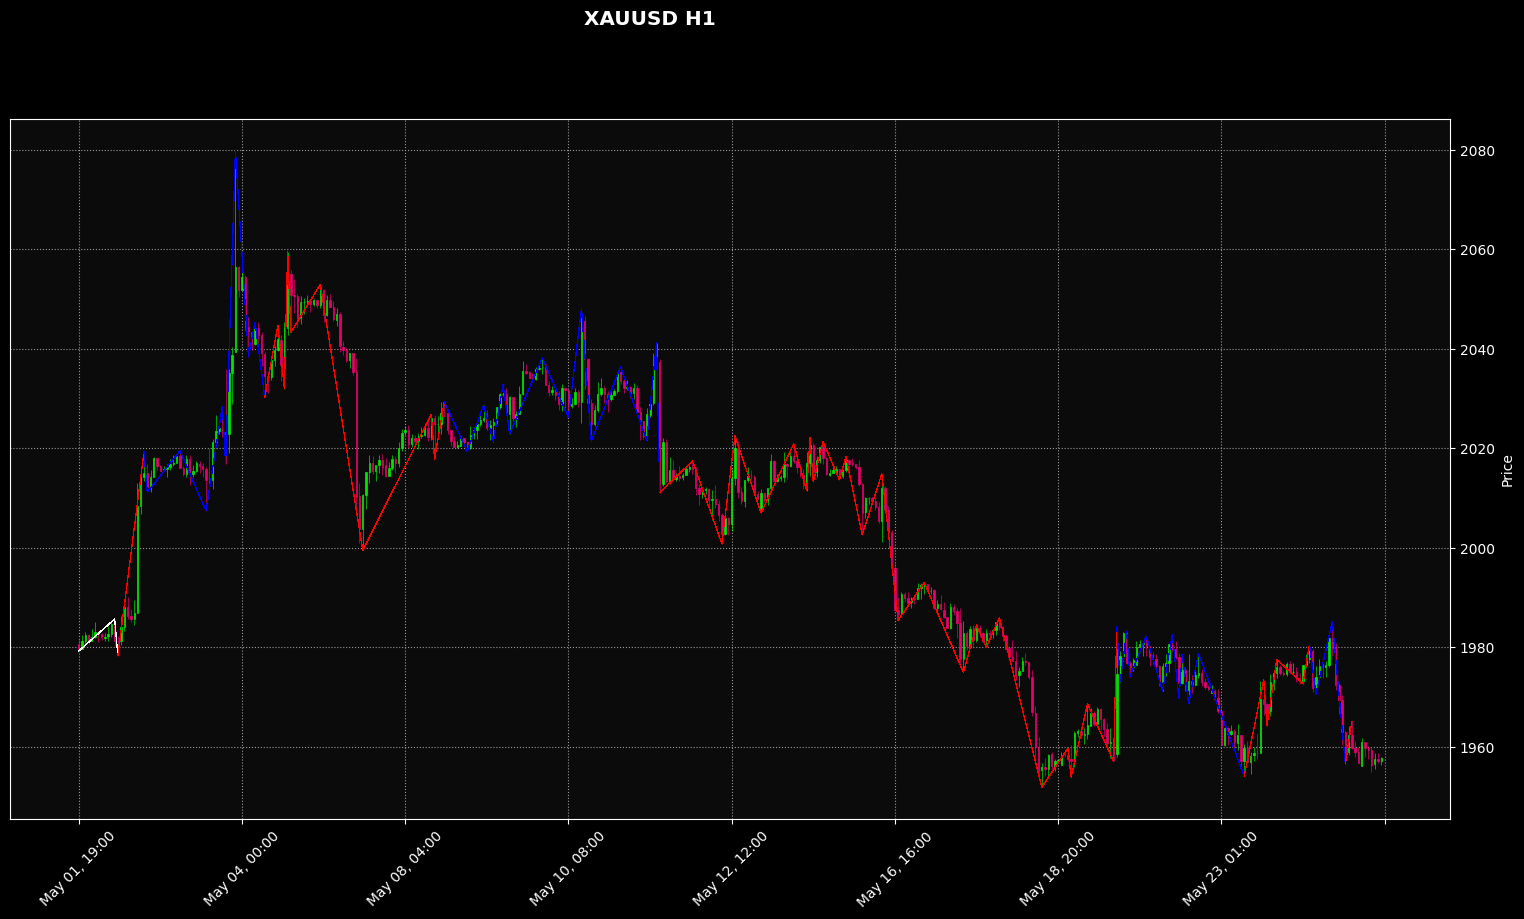

In [6]:

import mplfinance as mpf

data_window = 400
strat_candle = 1

# ZigZag Lines
zigzag_lines, trends = extract_list_of_lines(data[-strat_candle-data_window:-strat_candle])

# create custom style
mc = mpf.make_marketcolors(up='#00ff00',down='#ff0077',inherit=True)
s = mpf.make_mpf_style(base_mpf_style='nightclouds', marketcolors=mc, gridstyle=':', y_on_right=True)
# plot candlestick chart
title = 'XAUUSD H1'
mpf.plot(data[-strat_candle-data_window:-strat_candle], type='candle', style=s, title=title, figsize=(20, 10), figscale=1,
          alines=dict(alines = zigzag_lines, colors = trends, linewidths=0.2))



a) The Zigzag lines included start and end point of each leg and each point contains its date and price. What do you think is a better way to represent a leg that is fine to be used in k-means algorithm? Implement it and use it for the next parts of problem.

In [7]:

lines, trends = extract_list_of_lines(data)

legs = []

# Iterate over the lines and extract the leg information
for line in lines:
    start_date, start_price = line[0]
    end_date, end_price = line[1]

    time_length = end_date - start_date
    price_length = (end_price - start_price)

    leg = {
        'Start Date': start_date,
        'Start Price': start_price,
        'End Date': end_date,
        'End Price': end_price,
        'time length': time_length,
        'Price Length': price_length
    }
    legs.append(leg)

legs_df = pd.DataFrame(legs)
print(legs_df.head())
#print(legs[0]['Start Date'])

                 Start Date  Start Price                  End Date  End Price  \
0 2018-01-12 19:00:00+00:00     1339.301 2018-01-14 23:00:00+00:00   1335.842   
1 2018-01-14 23:00:00+00:00     1335.842 2018-01-15 05:00:00+00:00   1344.672   
2 2018-01-15 05:00:00+00:00     1344.672 2018-01-15 06:00:00+00:00   1340.122   
3 2018-01-15 06:00:00+00:00     1340.122 2018-01-15 09:00:00+00:00   1343.748   
4 2018-01-15 09:00:00+00:00     1343.748 2018-01-15 15:00:00+00:00   1338.641   

      time length  Price Length  
0 2 days 04:00:00        -3.459  
1 0 days 06:00:00         8.830  
2 0 days 01:00:00        -4.550  
3 0 days 03:00:00         3.626  
4 0 days 06:00:00        -5.107  


b)Using Zigzag lines create three datasets that contain the previous 2, 3 and 4 legs. (The trend of current leg should be included)

In [8]:
datasets_2_legs_bullish = []
datasets_2_legs_bearish = []
datasets_3_legs_bullish = []
datasets_3_legs_bearish = []
datasets_4_legs_bullish = []
datasets_4_legs_bearish = []

for i in range(2, len(legs)):
    prev_2_legs = legs[i-2:i]
    current_leg = legs[i]
    first_leg = legs[i-2]
    start_date = first_leg['Start Date']
    end_date = current_leg['End Date']
    time_length = int((end_date - start_date).total_seconds() / 3600)
    sum_price_length = round(sum(float(leg['Price Length']) for leg in legs[i-2:i+1])  , 2 )

    trend = 'bullish' if sum_price_length > 0 else 'bearish'
    dataset_2_legs = [trend] + prev_2_legs + [current_leg] + [time_length] + [sum_price_length]

    if trend == 'bullish':

        datasets_2_legs_bullish.append(dataset_2_legs)
    elif trend == 'bearish':

        datasets_2_legs_bearish.append(dataset_2_legs)

for i in range(3, len(legs)):
    prev_3_legs = legs[i-3:i]
    current_leg = legs[i]
    first_leg = legs[i-3]
    start_date = first_leg['Start Date']
    end_date = current_leg['End Date']
    time_length = int((end_date - start_date).total_seconds() / 3600)

    sum_price_length = round(sum(float(leg['Price Length']) for leg in legs[i-3:i+1])  , 2 )
    trend = 'bullish' if sum_price_length > 0 else 'bearish'
    dataset_3_legs = [trend] + prev_3_legs + [current_leg] + [time_length] + [sum_price_length]
    if trend == 'bullish':

        datasets_3_legs_bullish.append(dataset_3_legs)
    elif trend == 'bearish':

        datasets_3_legs_bearish.append(dataset_3_legs)

for i in range(4, len(legs)):
    prev_4_legs = legs[i-4:i]
    current_leg = legs[i]
    first_leg = legs[i-4]
    start_date = first_leg['Start Date']
    end_date = current_leg['End Date']
    time_length = int((end_date - start_date).total_seconds() / 3600)

    sum_price_length = round(sum(float(leg['Price Length']) for leg in legs[i-4:i+1])  , 2 )

    trend = 'bullish' if sum_price_length > 0 else 'bearish'
    dataset_4_legs = [trend] + prev_4_legs + [current_leg] + [time_length] + [sum_price_length]
    if trend == 'bullish':


        datasets_4_legs_bullish.append(dataset_4_legs)

    elif trend == 'bearish':

        datasets_4_legs_bearish.append(dataset_4_legs)


print( datasets_4_legs_bullish[1][1]['Start Date'] )  # Accessing start time for the second member)
print(sum_price_length)
print(datasets_4_legs_bullish[2])

2018-01-15 06:00:00+00:00
-25.62
['bullish', {'Start Date': Timestamp('2018-01-16 01:00:00+0000', tz='UTC'), 'Start Price': 1338.138, 'End Date': Timestamp('2018-01-16 02:00:00+0000', tz='UTC'), 'End Price': 1341.941, 'time length': Timedelta('0 days 01:00:00'), 'Price Length': 3.803000000000111}, {'Start Date': Timestamp('2018-01-16 02:00:00+0000', tz='UTC'), 'Start Price': 1341.941, 'End Date': Timestamp('2018-01-16 10:00:00+0000', tz='UTC'), 'End Price': 1331.841, 'time length': Timedelta('0 days 08:00:00'), 'Price Length': -10.100000000000136}, {'Start Date': Timestamp('2018-01-16 10:00:00+0000', tz='UTC'), 'Start Price': 1331.841, 'End Date': Timestamp('2018-01-16 12:00:00+0000', tz='UTC'), 'End Price': 1337.139, 'time length': Timedelta('0 days 02:00:00'), 'Price Length': 5.298000000000002}, {'Start Date': Timestamp('2018-01-16 12:00:00+0000', tz='UTC'), 'Start Price': 1337.139, 'End Date': Timestamp('2018-01-16 14:00:00+0000', tz='UTC'), 'End Price': 1331.972, 'time length': Tim

c) Run K-means algorithm for each dataset. You should split data for each trend and find 5 clusters for each one. Plot the patterns you found (There should be 6 different sets of patterns).

In [9]:
from sklearn.cluster import KMeans
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")



# Function to get cluster dataset and centroids
def get_centroid_cluster(data, k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    cluster_labels = kmeans.predict(data)
    cluster_centroids = kmeans.cluster_centers_

    # Find nearest datapoint to the center of each cluster(clustroids)
    nearest_datapoints = []
    for centroid in cluster_centroids:
        distances = np.linalg.norm(data - centroid, axis=1)
        nearest_index = np.argmin(distances)
        nearest_datapoints.append(data[nearest_index])

    # Filter data points assigned to the cluster centroids
    cluster_datasets = [data[cluster_labels == centroid_idx] for centroid_idx in range(k)]

    return cluster_datasets, cluster_centroids, nearest_datapoints


def find_dataset_by_datapoint(datasets, time_length, sum_price_length):


    for dataset in datasets:
        dataset_time_length = dataset[-2]
        dataset_sum_price_length = dataset[-1]
        if dataset_time_length == time_length and dataset_sum_price_length == sum_price_length:
            return dataset
    return None


print(datasets_3_legs_bullish[1])
# Get time length and current leg as data point for each dataset
data_2_legs_bullish = np.array([[leg[-2], leg[-1]] for leg in datasets_2_legs_bullish])
data_2_legs_bearish = np.array([[leg[-2], leg[-1]] for leg in datasets_2_legs_bearish])

data_3_legs_bullish = np.array([[leg[-2], leg[-1]] for leg in datasets_3_legs_bullish])
data_3_legs_bearish = np.array([[leg[-2], leg[-1]] for leg in datasets_3_legs_bearish])

data_4_legs_bullish = np.array([[leg[-2], leg[-1]] for leg in datasets_4_legs_bullish])
data_4_legs_bearish = np.array([[leg[-2], leg[-1]] for leg in datasets_4_legs_bearish])


print(data_3_legs_bullish)
# Run k-means clustering on each dataset

cluster_dataset_2_legs_bullish ,  centroids_2_legs_bullish , clustroid_2_legs_bullish  = get_centroid_cluster(data_2_legs_bullish, 5)
cluster_dataset_2_legs_bearish ,  centroids_2_legs_bearish , clustroid_2_legs_bearish  = get_centroid_cluster(data_2_legs_bearish, 5)

cluster_dataset_3_legs_bullish ,  centroids_3_legs_bullish , clustroid_3_legs_bullish  = get_centroid_cluster(data_3_legs_bullish, 5)
cluster_dataset_3_legs_bearish ,  centroids_2_legs_bearish , clustroid_3_legs_bearish  = get_centroid_cluster(data_3_legs_bearish, 5)

cluster_dataset_4_legs_bullish ,  centroids_4_legs_bullish , clustroid_4_legs_bullish  = get_centroid_cluster(data_4_legs_bullish, 5)
cluster_dataset_4_legs_bullish ,  centroids_2_legs_bearish , clustroid_4_legs_bearish  = get_centroid_cluster(data_4_legs_bearish, 5)




['bullish', {'Start Date': Timestamp('2018-01-14 23:00:00+0000', tz='UTC'), 'Start Price': 1335.842, 'End Date': Timestamp('2018-01-15 05:00:00+0000', tz='UTC'), 'End Price': 1344.672, 'time length': Timedelta('0 days 06:00:00'), 'Price Length': 8.829999999999927}, {'Start Date': Timestamp('2018-01-15 05:00:00+0000', tz='UTC'), 'Start Price': 1344.672, 'End Date': Timestamp('2018-01-15 06:00:00+0000', tz='UTC'), 'End Price': 1340.122, 'time length': Timedelta('0 days 01:00:00'), 'Price Length': -4.5499999999999545}, {'Start Date': Timestamp('2018-01-15 06:00:00+0000', tz='UTC'), 'Start Price': 1340.122, 'End Date': Timestamp('2018-01-15 09:00:00+0000', tz='UTC'), 'End Price': 1343.748, 'time length': Timedelta('0 days 03:00:00'), 'Price Length': 3.6259999999999764}, {'Start Date': Timestamp('2018-01-15 09:00:00+0000', tz='UTC'), 'Start Price': 1343.748, 'End Date': Timestamp('2018-01-15 15:00:00+0000', tz='UTC'), 'End Price': 1338.641, 'time length': Timedelta('0 days 06:00:00'), 'Pric

In [15]:
###find dataset for every centroid with k = 5
clustroid_datasets = {
    "2_legs_bullish": [],
    "2_legs_bearish": [],
    "3_legs_bullish": [],
    "3_legs_bearish": [],
    "4_legs_bullish": [],
    "4_legs_bearish": []
}

clustroid_data = {
    "2_legs_bullish": data_2_legs_bullish,
    "2_legs_bearish": data_2_legs_bearish,
    "3_legs_bullish": data_3_legs_bullish,
    "3_legs_bearish": data_3_legs_bearish,
    "4_legs_bullish": data_4_legs_bullish,
    "4_legs_bearish": data_4_legs_bearish
}

clustroid_datasets_keys = clustroid_datasets.keys()

for key in clustroid_datasets_keys:
    clustroid_list = eval(f"clustroid_{key}")
    dataset_list = eval(f"datasets_{key}")

    for clustroid in clustroid_list:
        dataset = find_dataset_by_datapoint(dataset_list, clustroid[0], clustroid[1])
        if dataset is not None:
            clustroid_datasets[key].append(dataset)




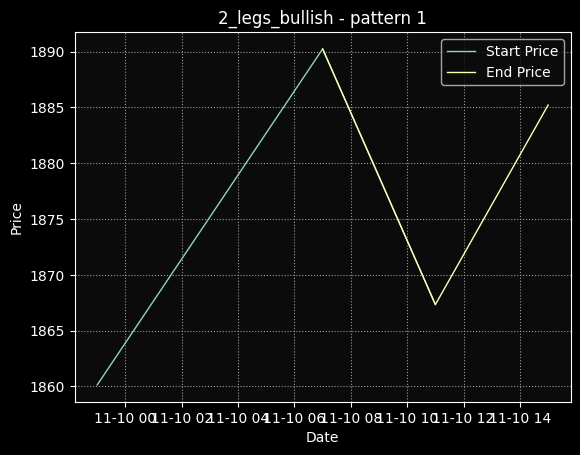

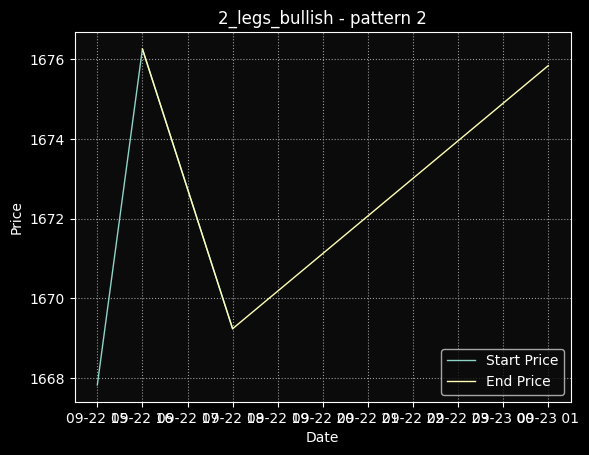

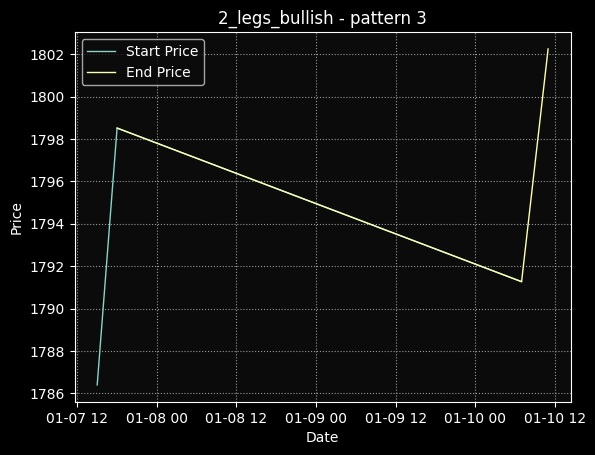

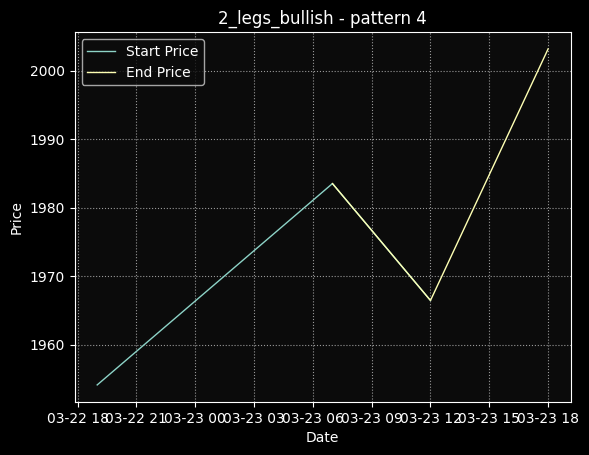

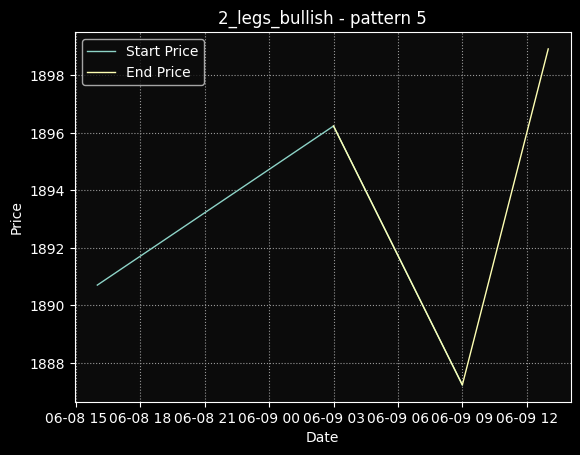

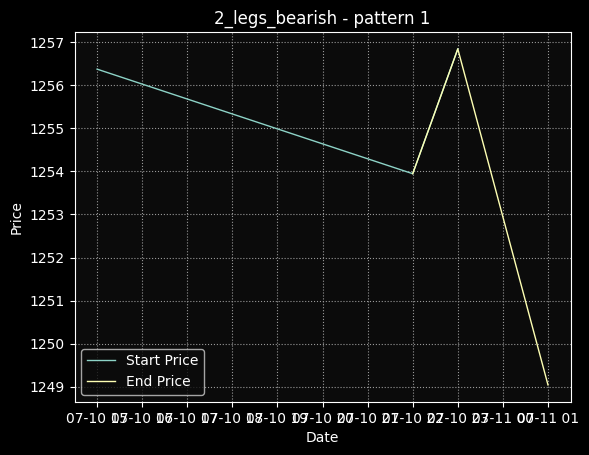

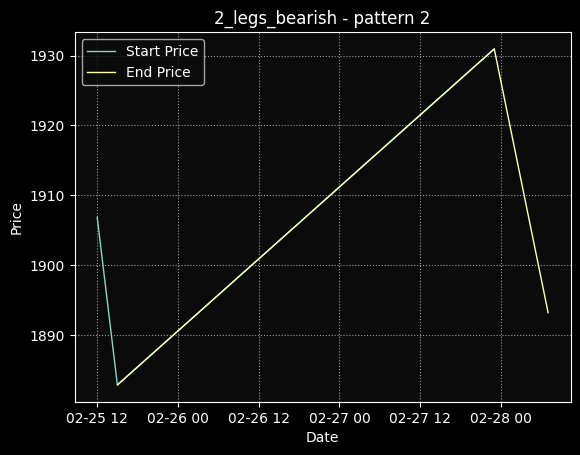

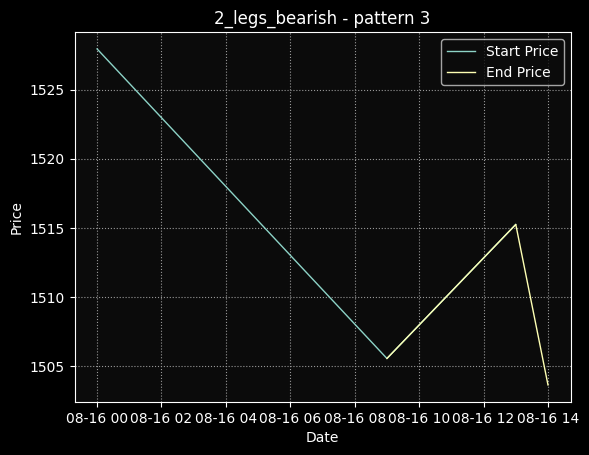

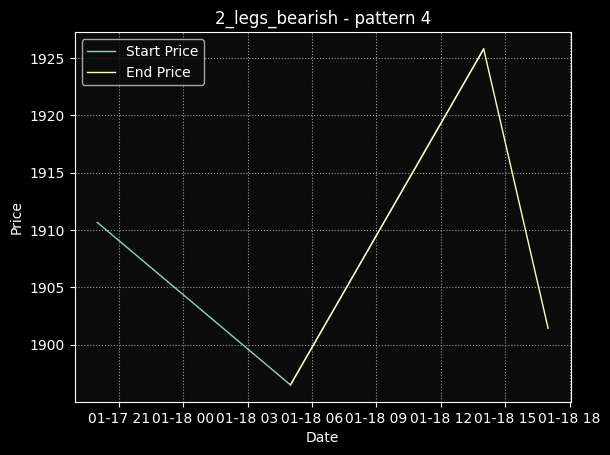

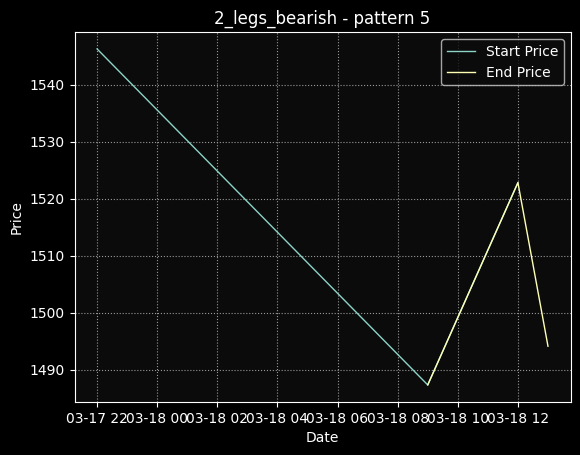

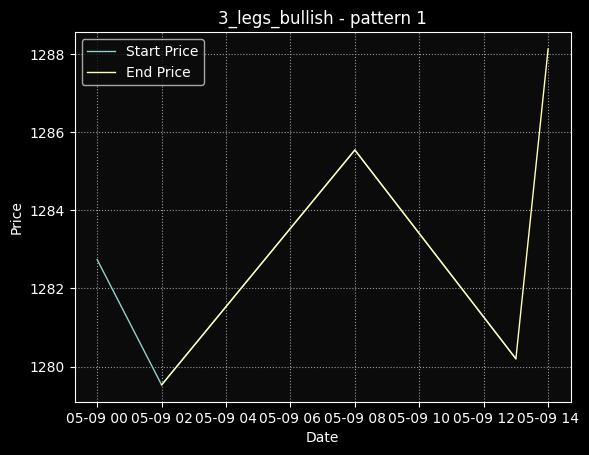

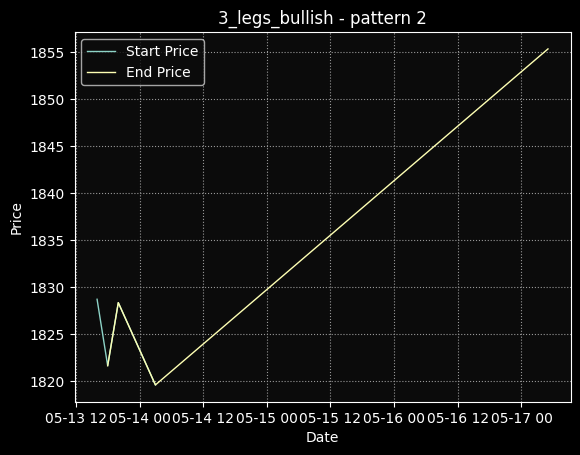

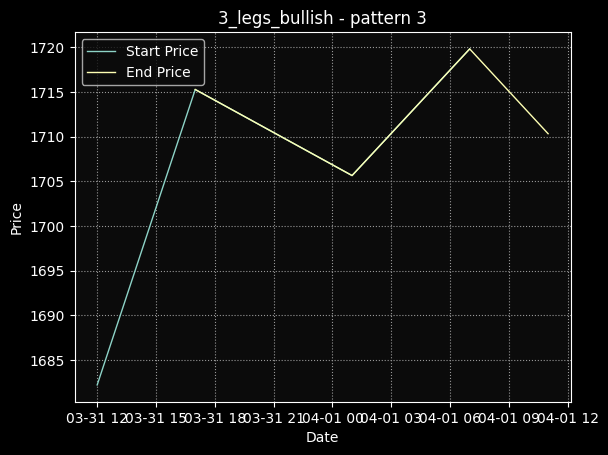

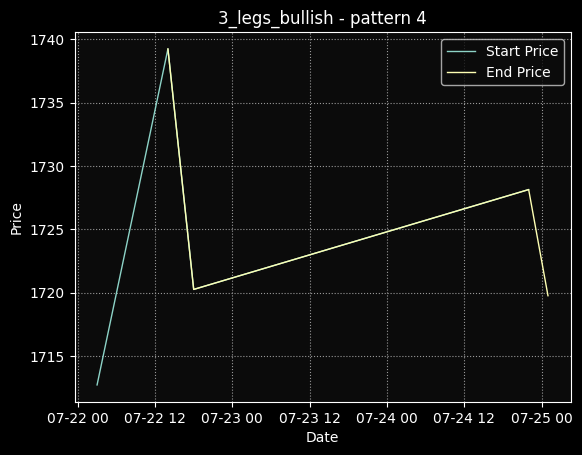

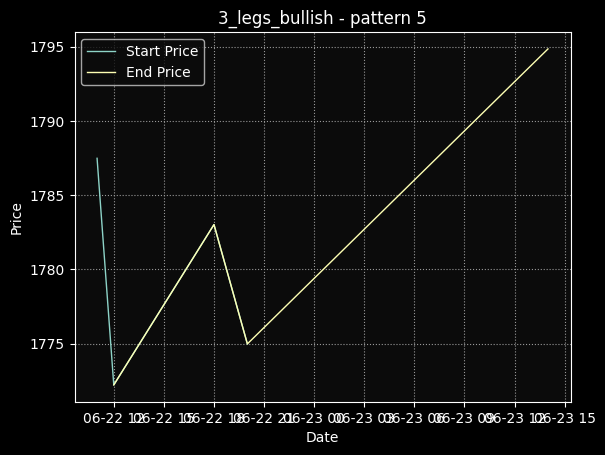

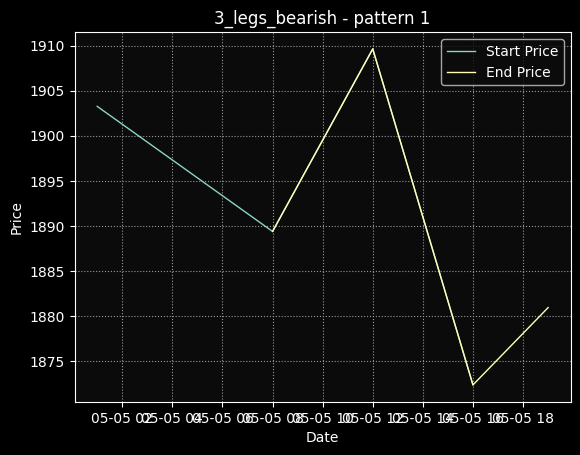

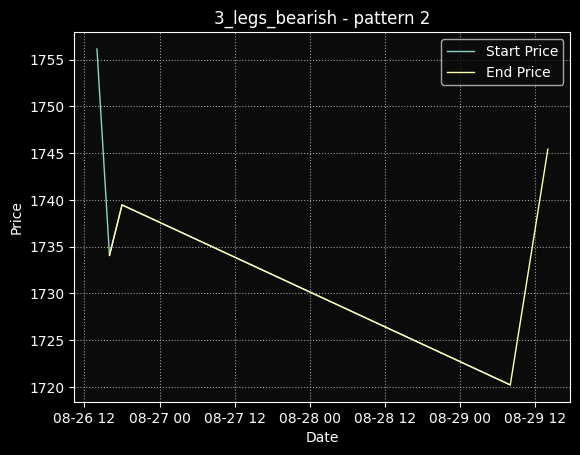

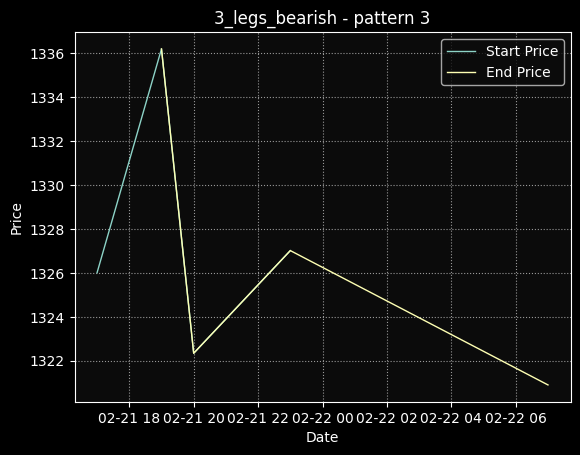

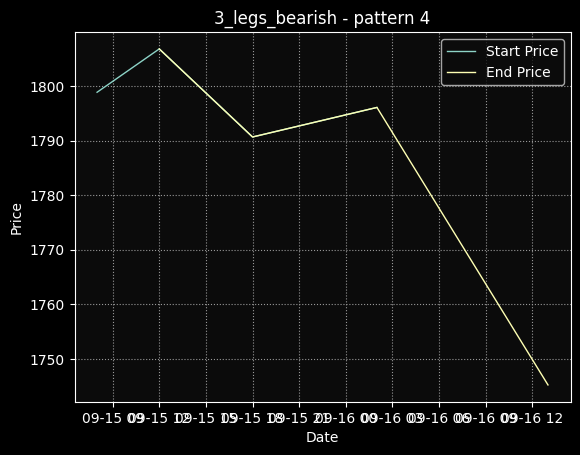

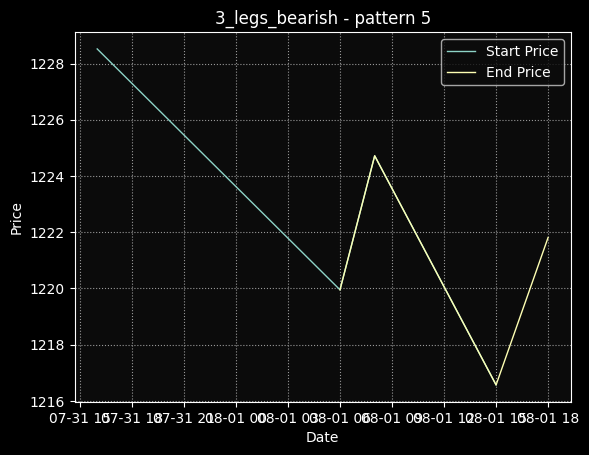

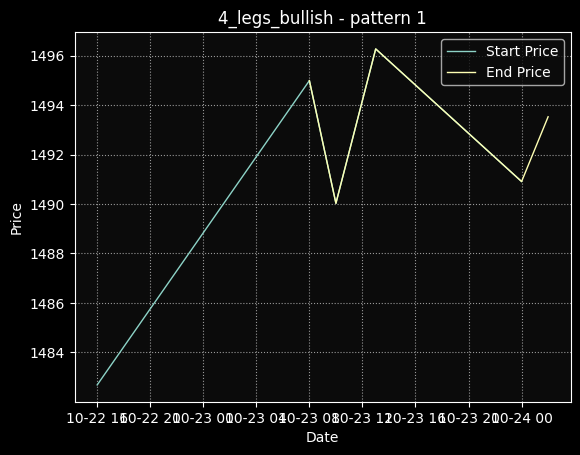

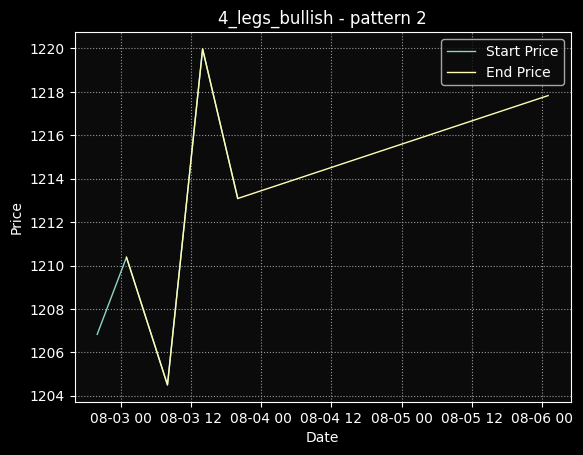

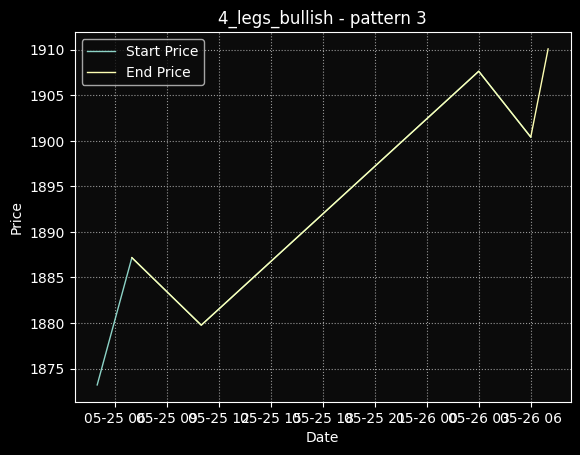

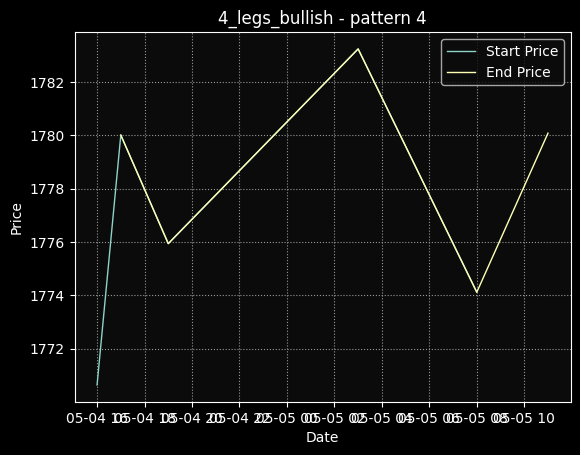

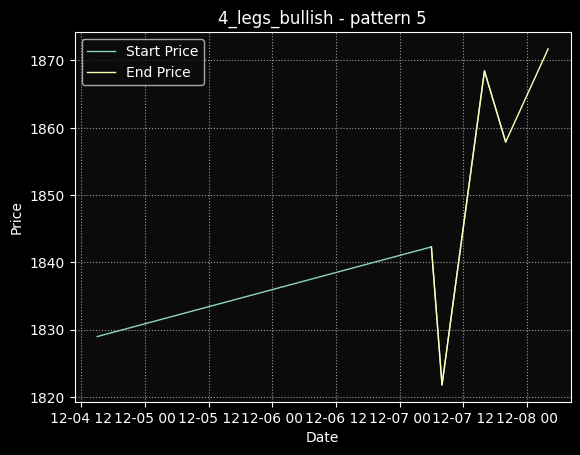

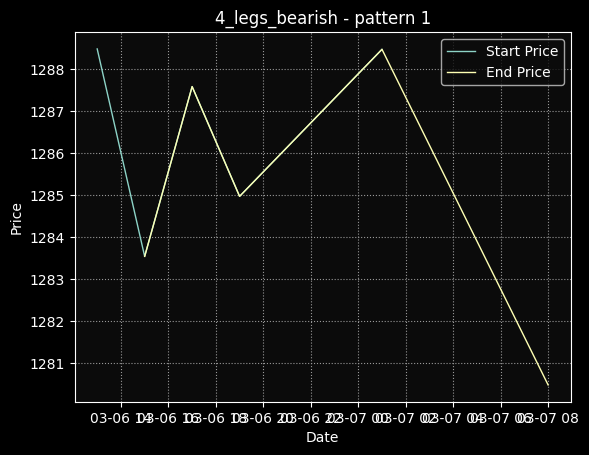

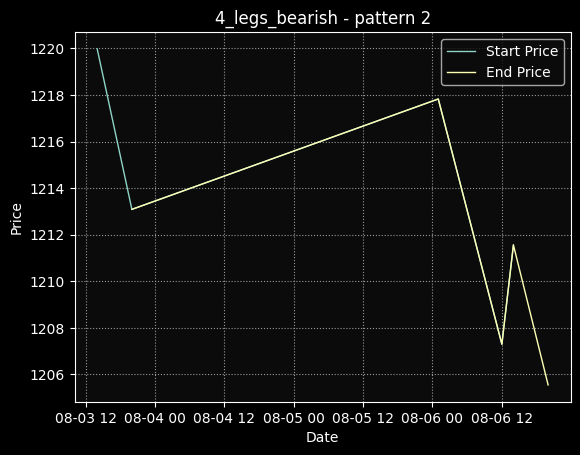

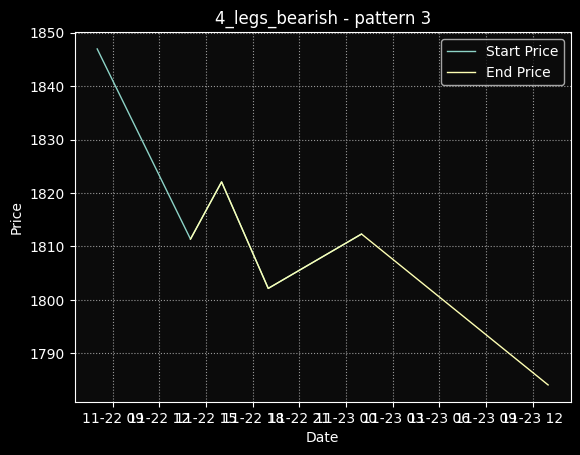

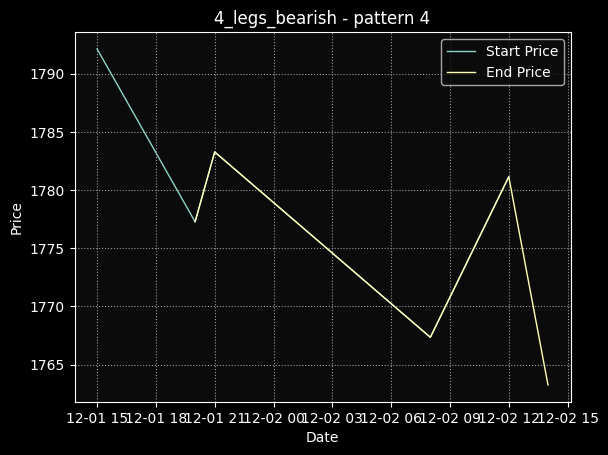

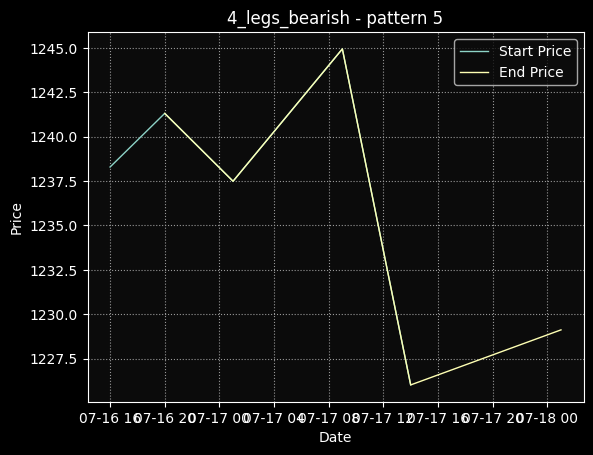

In [11]:
import matplotlib.pyplot as plt

# Iterate over the keys in clustroid_datasets
for category in clustroid_datasets.keys():
    datasets = clustroid_datasets[category]  # Get the datasets for the current category

    # Iterate over the datasets in the current category
    for dataset in datasets:
        start_prices = []
        end_prices = []
        start_dates = []
        end_dates = []

        # Iterate over the legs in the current dataset
        for leg in dataset[1:-2]:  # Exclude trend, time_length, and sum_price_length
            start_prices.append(leg['Start Price'])
            end_prices.append(leg['End Price'])
            start_dates.append(leg['Start Date'])
            end_dates.append(leg['End Date'])

        # Plot the pattern
        plt.plot(start_dates, start_prices, label='Start Price')
        plt.plot(end_dates, end_prices, label='End Price')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'{category} - pattern {datasets.index(dataset) + 1}')
        plt.legend()
        plt.show()

d) Show the path of centers movement only for dataset that contains 2 legs. (You can use a 2D chart because there’s only two features in this dataset)

5


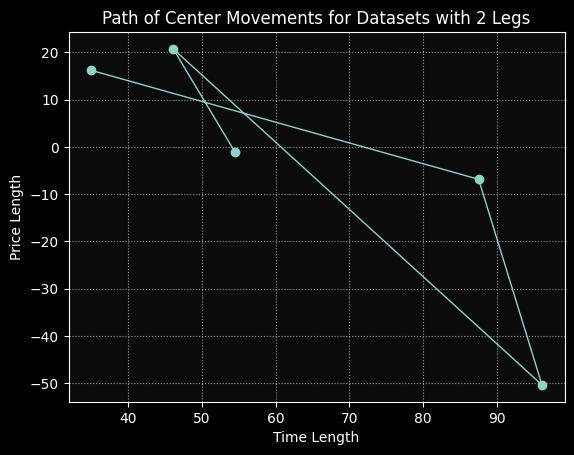

In [12]:
import matplotlib.pyplot as plt

# Extract the centroids of the datasets containing 2 legs
centroids_2_legs = centroids_2_legs_bullish + centroids_2_legs_bearish
print(len(centroids_2_legs))
# Extract the time length and price length coordinates of the centroids
time_lengths = [centroid[0] for centroid in centroids_2_legs]
price_lengths = [centroid[1] for centroid in centroids_2_legs]

# Plot the path of center movements
plt.plot(time_lengths, price_lengths, marker='o')
plt.xlabel('Time Length')
plt.ylabel('Price Length')
plt.title('Path of Center Movements for Datasets with 2 Legs')
plt.show()

e) Find the best hyperparameter for K-means using the elbow method. Extract and plot the patterns you found with the new number of clusters.

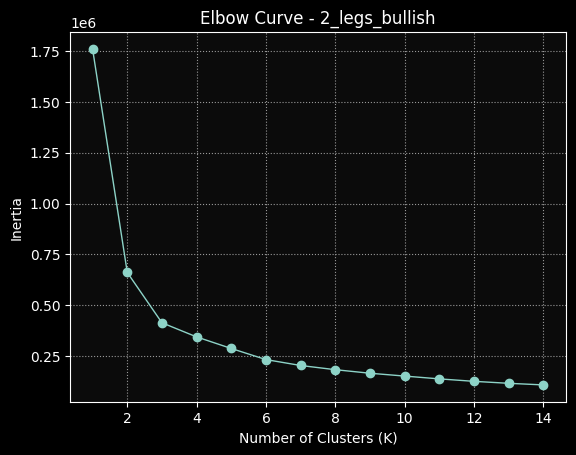

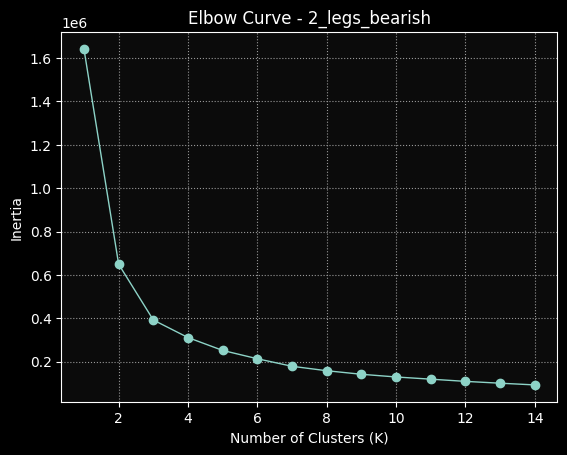

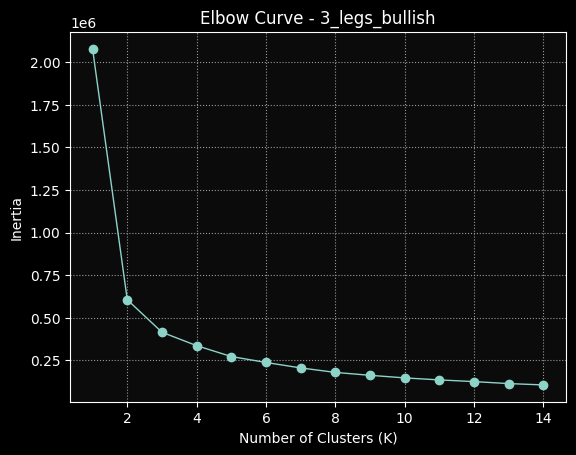

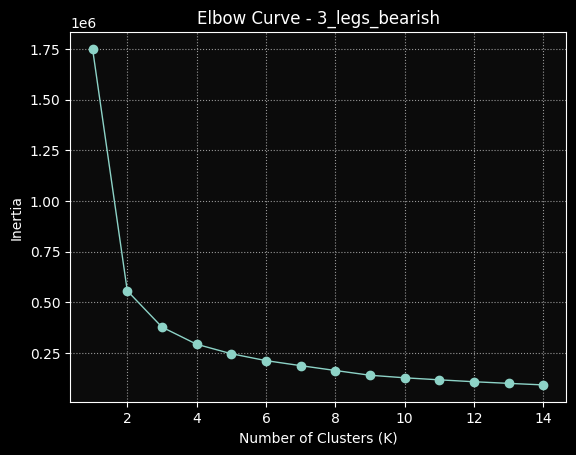

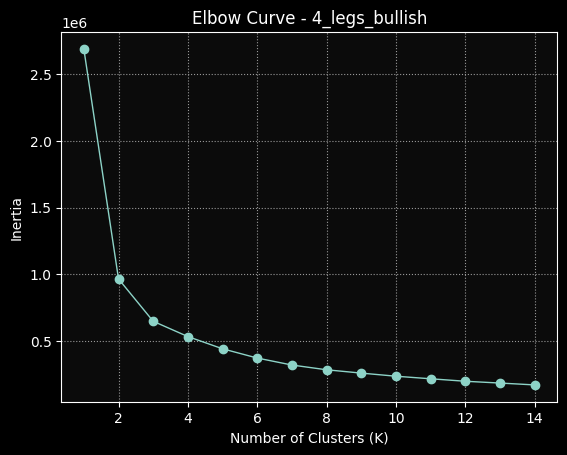

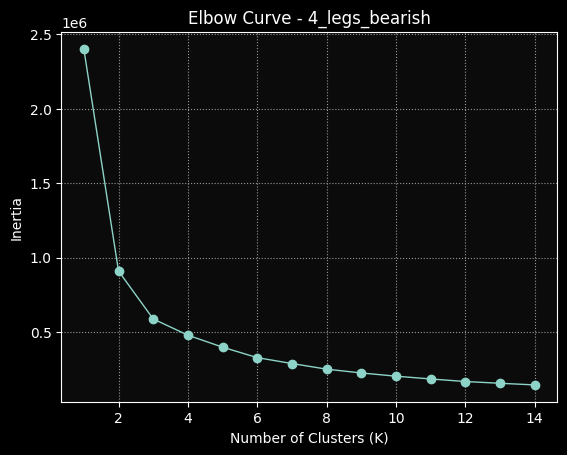

In [16]:
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

dataset_names = ["2_legs_bullish", "2_legs_bearish", "3_legs_bullish", "3_legs_bearish", "4_legs_bullish", "4_legs_bearish"]
datasets = [data_2_legs_bullish, data_2_legs_bearish, data_3_legs_bullish, data_3_legs_bearish, data_4_legs_bullish, data_4_legs_bearish]

for i, dataset in enumerate(datasets):
    inertias = []
    k_values = range(1, 15)

    for k in k_values:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(dataset)
        inertias.append(kmeans.inertia_)

    # Plot the elbow curve for the current dataset
    plt.plot(k_values, inertias, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Curve - {dataset_names[i]}')
    plt.show()



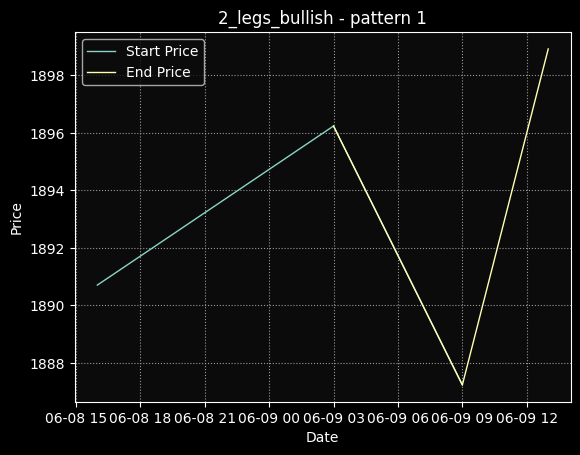

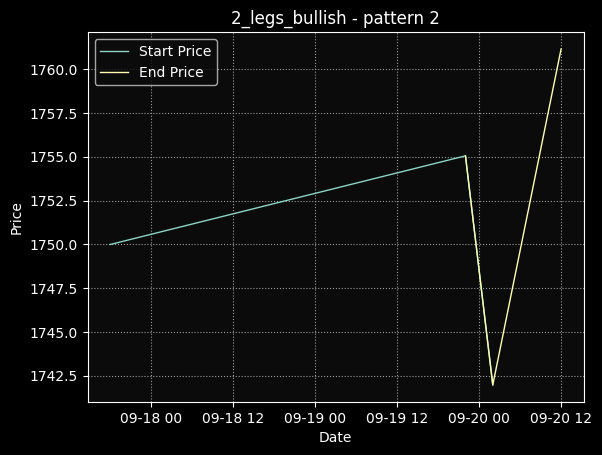

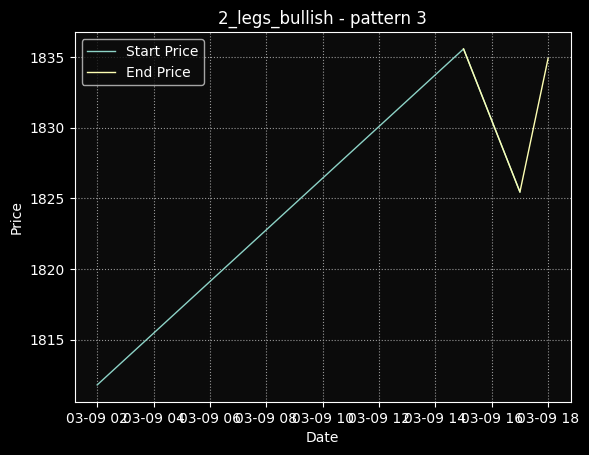

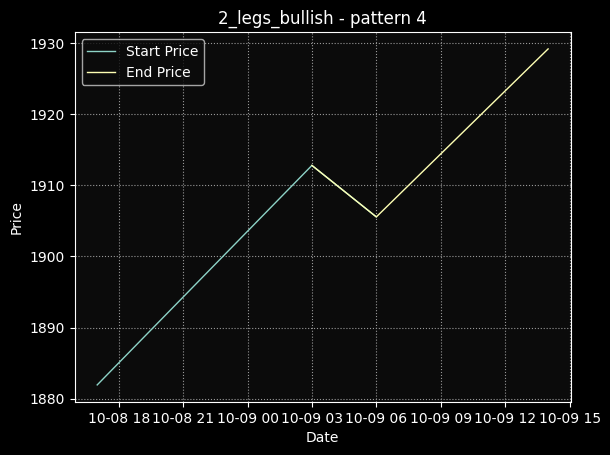

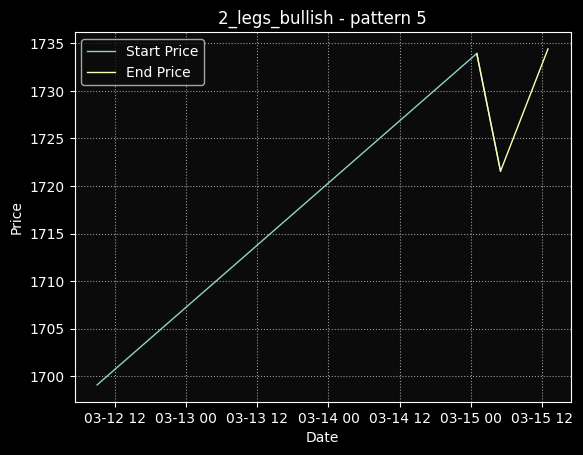

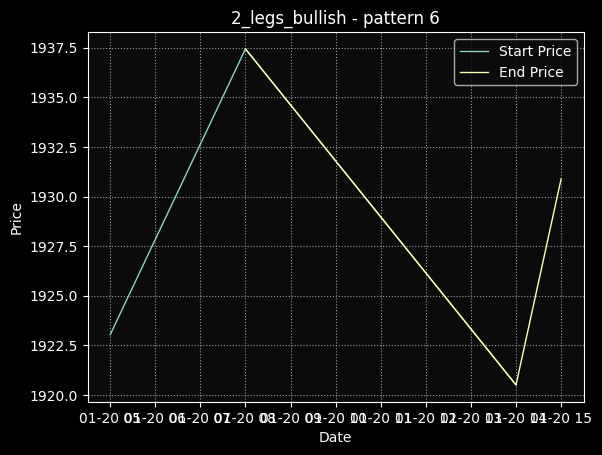

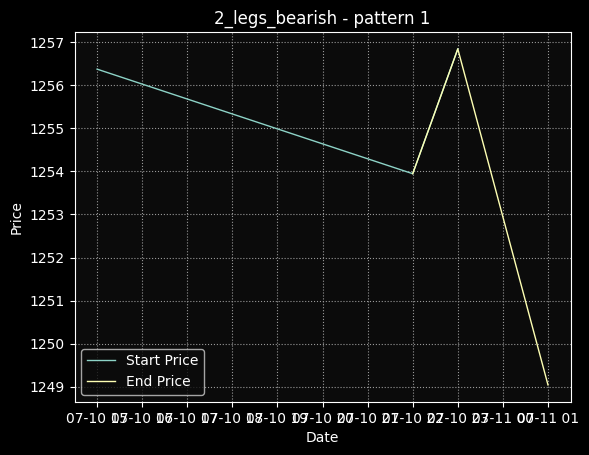

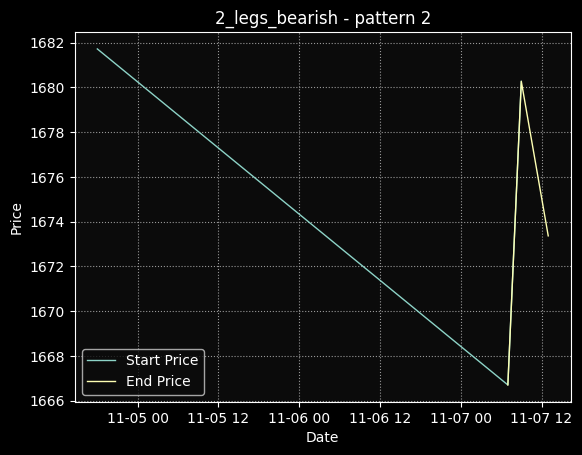

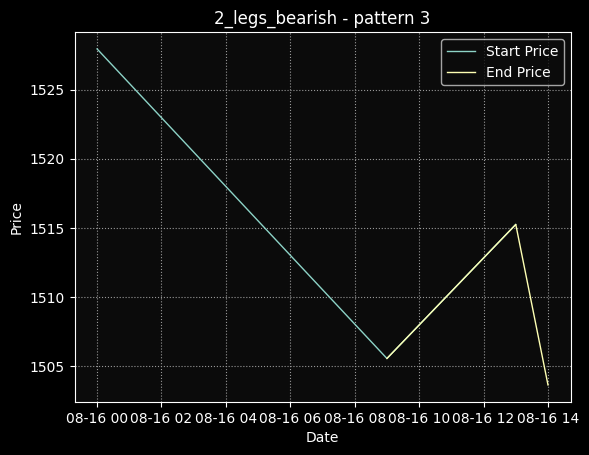

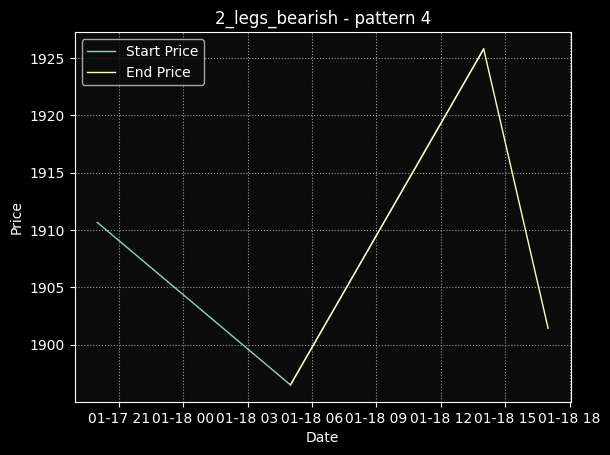

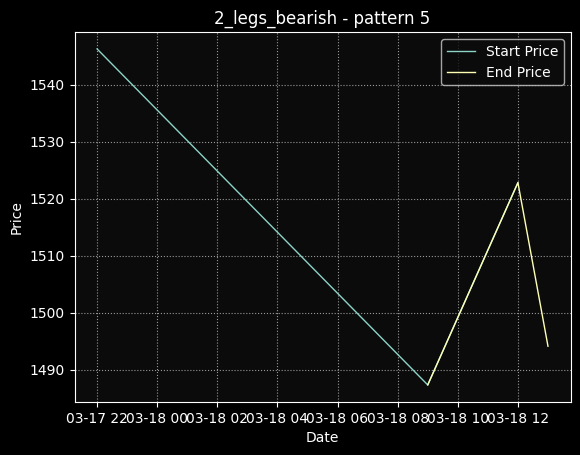

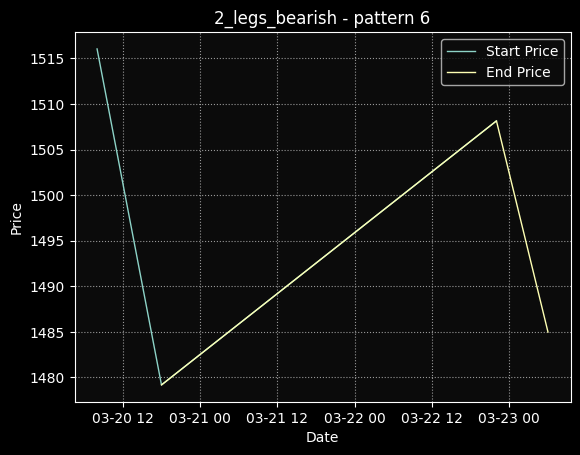

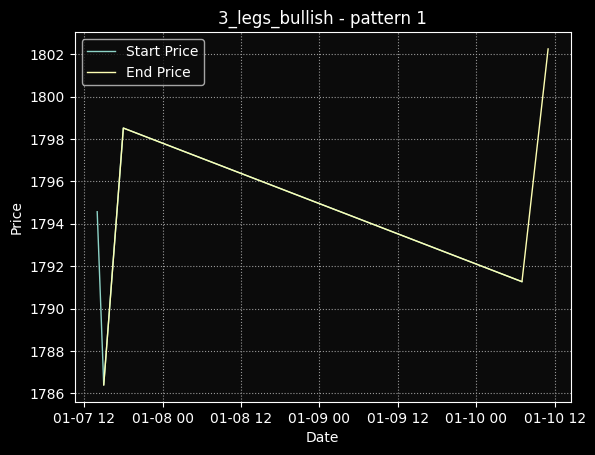

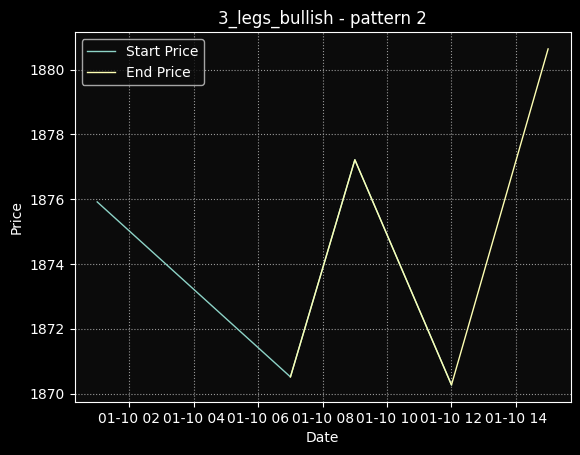

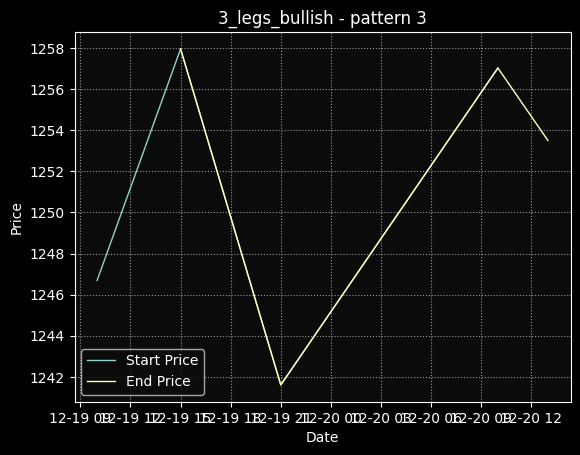

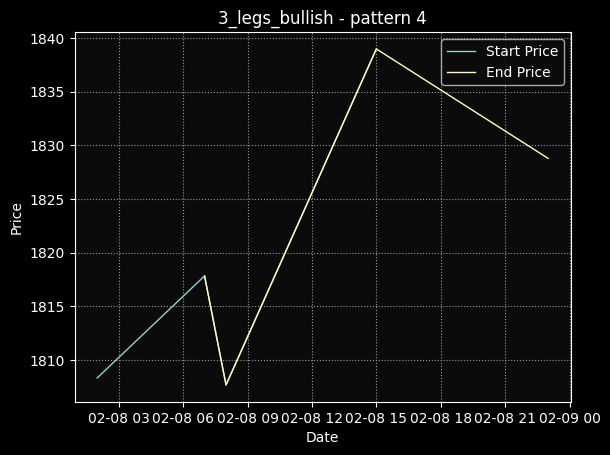

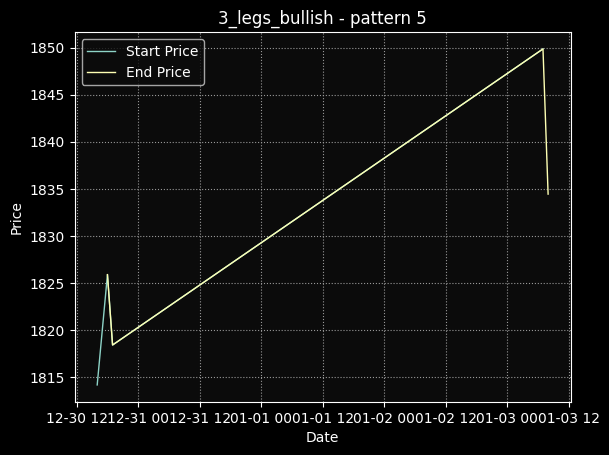

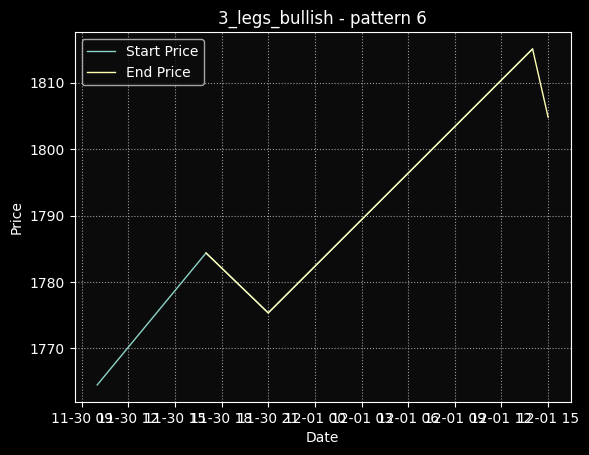

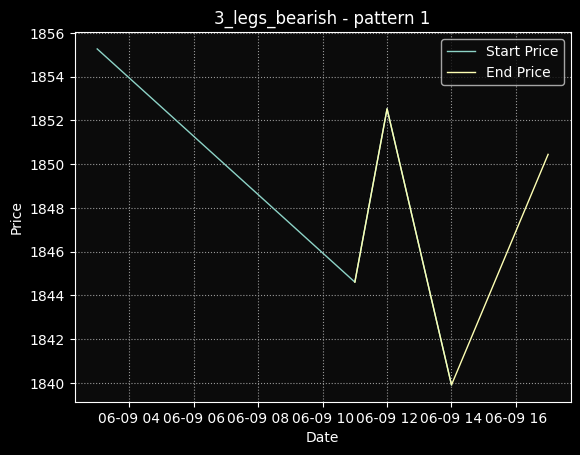

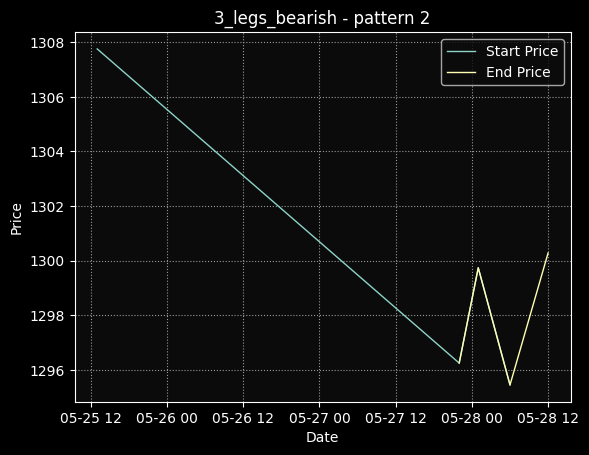

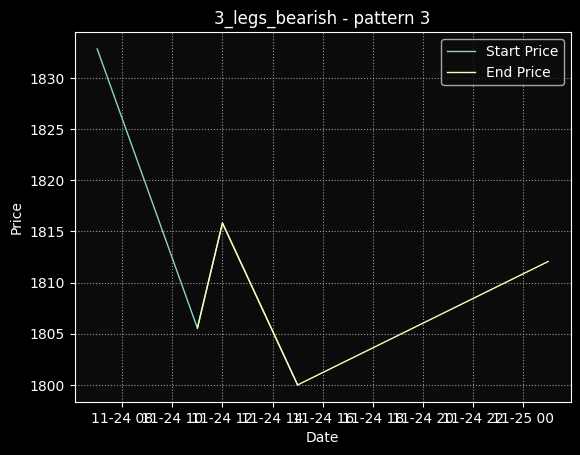

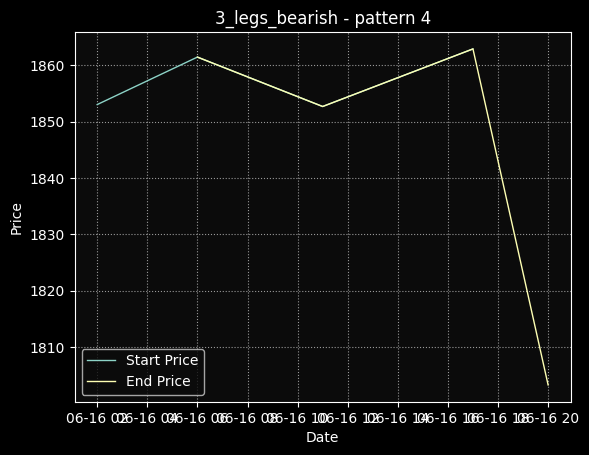

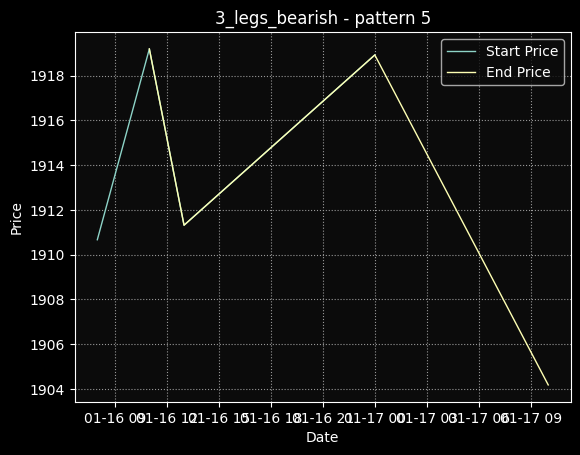

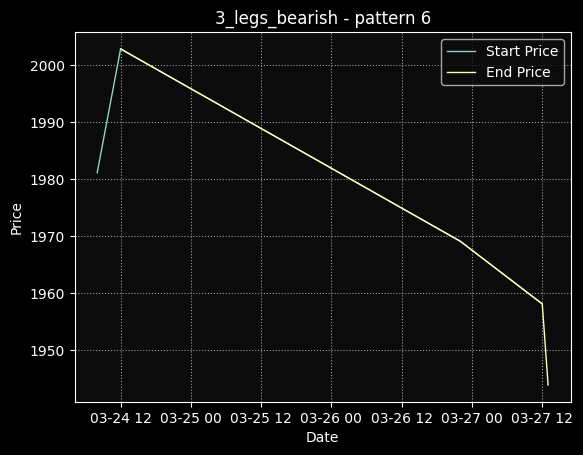

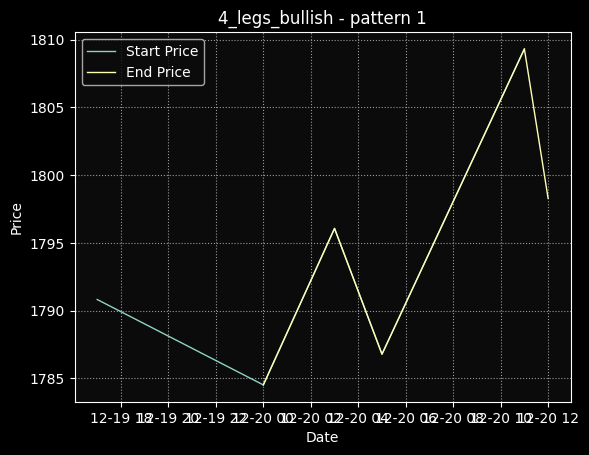

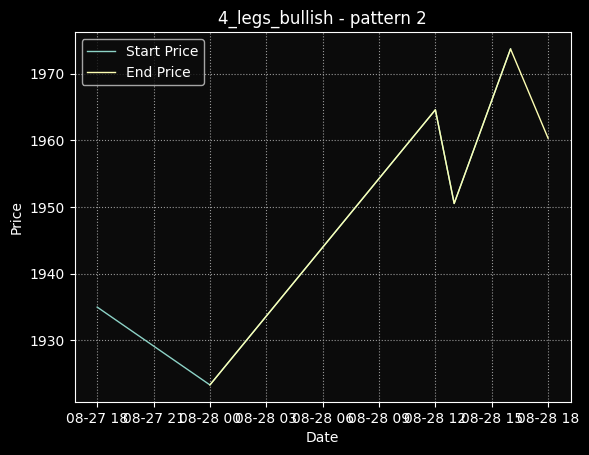

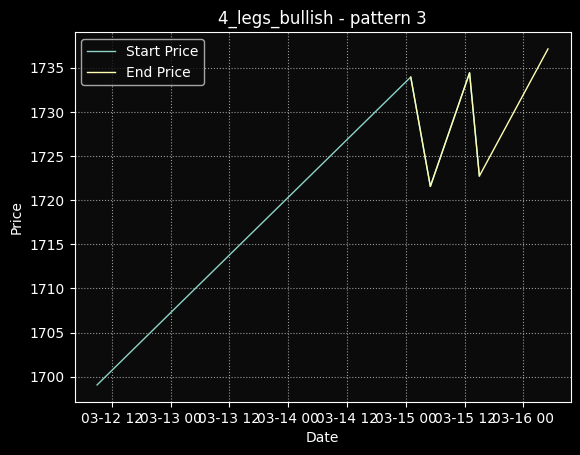

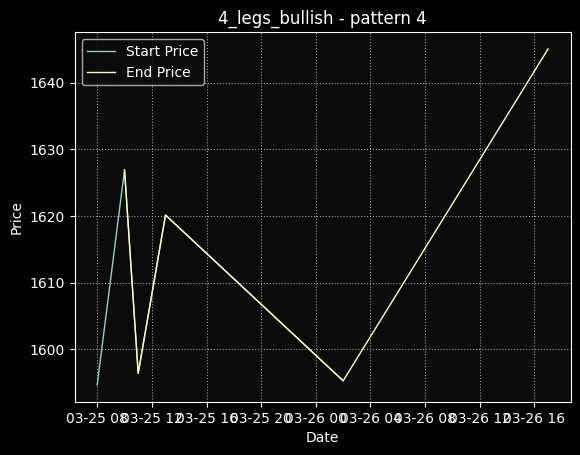

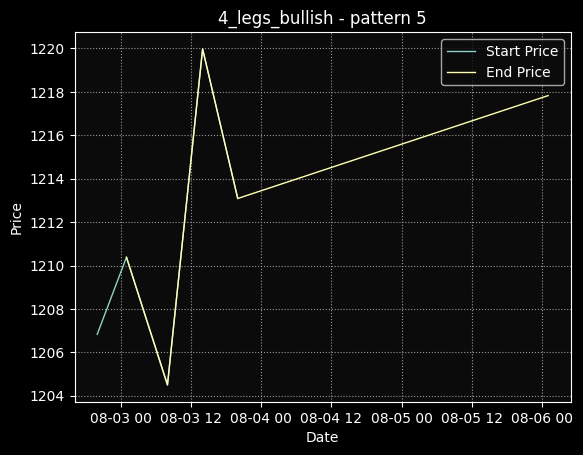

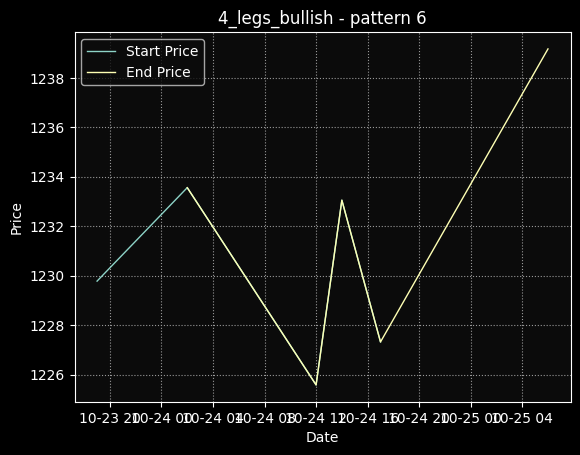

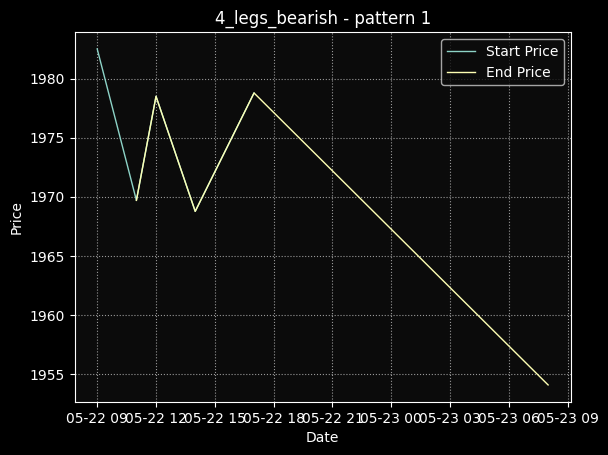

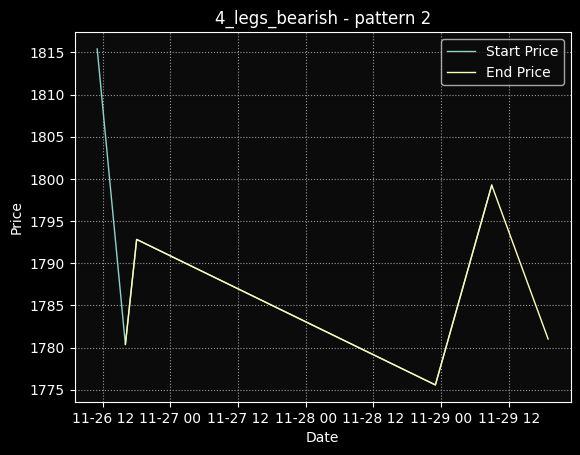

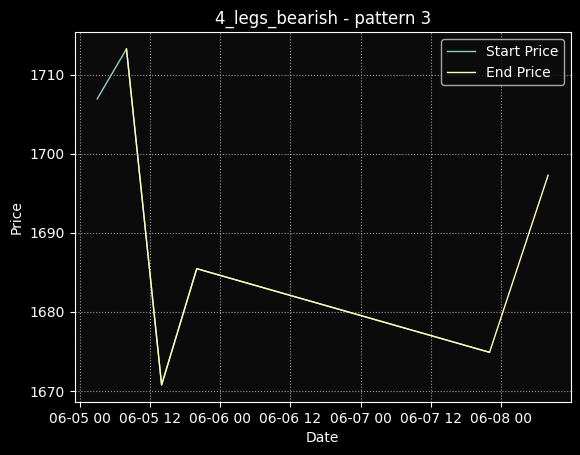

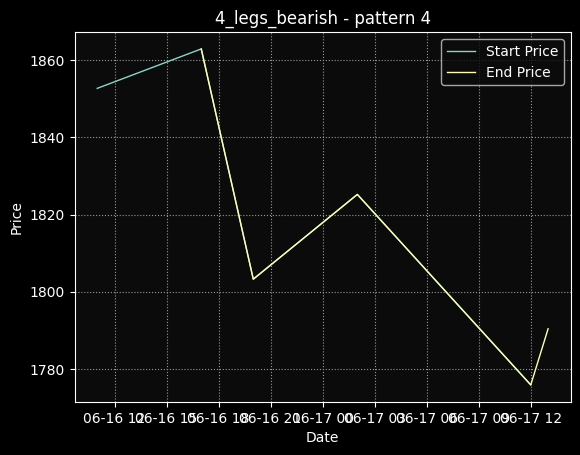

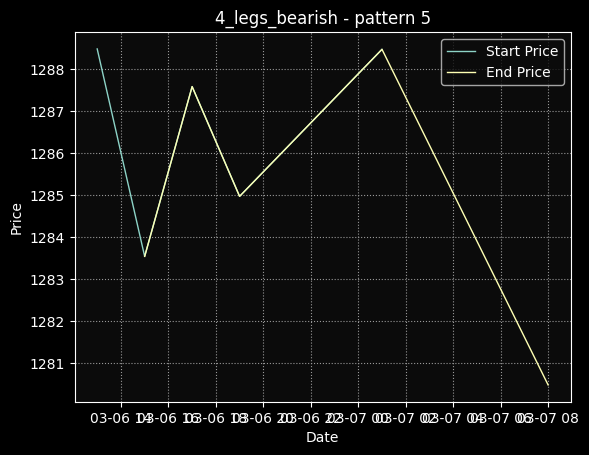

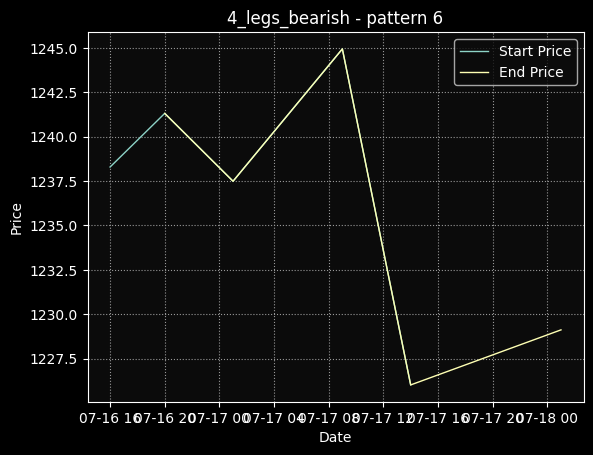

In [14]:


warnings.filterwarnings("ignore")

###find dataset for every centroid with k = 6
clustroid_datasets = {
    "2_legs_bullish": [],
    "2_legs_bearish": [],
    "3_legs_bullish": [],
    "3_legs_bearish": [],
    "4_legs_bullish": [],
    "4_legs_bearish": []
}

clustroid_data = {
    "2_legs_bullish": data_2_legs_bullish,
    "2_legs_bearish": data_2_legs_bearish,
    "3_legs_bullish": data_3_legs_bullish,
    "3_legs_bearish": data_3_legs_bearish,
    "4_legs_bullish": data_4_legs_bullish,
    "4_legs_bearish": data_4_legs_bearish
}

cluster_dataset_2_legs_bullish ,  centroids_2_legs_bullish , clustroid_2_legs_bullish  = get_centroid_cluster(data_2_legs_bullish, 6)
cluster_dataset_2_legs_bearish ,  centroids_2_legs_bearish , clustroid_2_legs_bearish  = get_centroid_cluster(data_2_legs_bearish, 6)

cluster_dataset_3_legs_bullish ,  centroids_3_legs_bullish , clustroid_3_legs_bullish  = get_centroid_cluster(data_3_legs_bullish, 6)
cluster_dataset_3_legs_bearish ,  centroids_2_legs_bearish , clustroid_3_legs_bearish  = get_centroid_cluster(data_3_legs_bearish, 6)

cluster_dataset_4_legs_bullish ,  centroids_4_legs_bullish , clustroid_4_legs_bullish  = get_centroid_cluster(data_4_legs_bullish, 6)
cluster_dataset_4_legs_bullish ,  centroids_2_legs_bearish , clustroid_4_legs_bearish  = get_centroid_cluster(data_4_legs_bearish, 6)

clustroid_datasets_keys = clustroid_datasets.keys()

for key in clustroid_datasets_keys:
    clustroid_list = eval(f"clustroid_{key}")
    dataset_list = eval(f"datasets_{key}")

    for clustroid in clustroid_list:
        dataset = find_dataset_by_datapoint(dataset_list, clustroid[0], clustroid[1])
        if dataset is not None:
            clustroid_datasets[key].append(dataset)

import matplotlib.pyplot as plt

# Iterate over the keys in clustroid_datasets
for category in clustroid_datasets.keys():
    datasets = clustroid_datasets[category]  # Get the datasets for the current category

    # Iterate over the datasets in the current category
    for dataset in datasets:
        start_prices = []
        end_prices = []
        start_dates = []
        end_dates = []

        # Iterate over the legs in the current dataset
        for leg in dataset[1:-2]:  # Exclude trend, time_length, and sum_price_length
            start_prices.append(leg['Start Price'])
            end_prices.append(leg['End Price'])
            start_dates.append(leg['Start Date'])
            end_dates.append(leg['End Date'])

        # Plot the pattern
        plt.plot(start_dates, start_prices, label='Start Price')
        plt.plot(end_dates, end_prices, label='End Price')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'{category} - pattern {datasets.index(dataset) + 1}')
        plt.legend()
        plt.show()